# 🟩 1. Data Loading & Preprocessing


## 1.1 Imports and notebook settings


In [ ]:

!pip install --upgrade --quiet protobuf==3.20.*

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Core imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses, optimizers

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

print("TensorFlow version:", tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
TensorFlow version: 2.19.0


## 1.2 Load dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Credit Cards frauds/creditcard.csv")
print("Shape:", df.shape)
df.head()

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.3 Basic checks & class imbalance


In [ ]:
print("Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head())

print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True).rename('proportion'))


Missing values per column:
Time    0
V1      0
V2      0
V3      0
V4      0
dtype: int64

Class distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## 1.4 Train/validation split & scaling


In [ ]:
# We will train autoencoder on mostly non-fraud data for realistic unsupervised training.
# Create a train set using only non-fraud transactions (Class==0)
df_nonfraud = df[df['Class'] == 0].copy()
df_fraud = df[df['Class'] == 1].copy()

# Shuffle
df_nonfraud = df_nonfraud.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Use 90% of non-fraud for training, 10% non-fraud for val + all fraud for validation evaluation
train_frac = 0.90
n_train = int(len(df_nonfraud) * train_frac)
train_df = df_nonfraud.iloc[:n_train].reset_index(drop=True)
val_nonfraud = df_nonfraud.iloc[n_train:].reset_index(drop=True)

# Validation set will include both some non-fraud and all fraud, to evaluate reconstruction separation
val_df = pd.concat([val_nonfraud, df_fraud]).sample(frac=1.0, random_state=42).reset_index(drop=True)

# Features used for training (exclude Time and Class)
features = [c for c in df.columns if c not in ['Time', 'Class']]
X_train = train_df[features].values
X_val = val_df[features].values
X_all = df[features].values  # for full-dataset predictions later

# Scale features (fit on training only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_all_scaled = scaler.transform(X_all)

print("Train shape:", X_train_scaled.shape, "Validation shape:", X_val_scaled.shape)


Train shape: (255883, 29) Validation shape: (28924, 29)


# 🟦 2. Exploratory Data Analysis (EDA)


## 2.1 Class distribution & percent


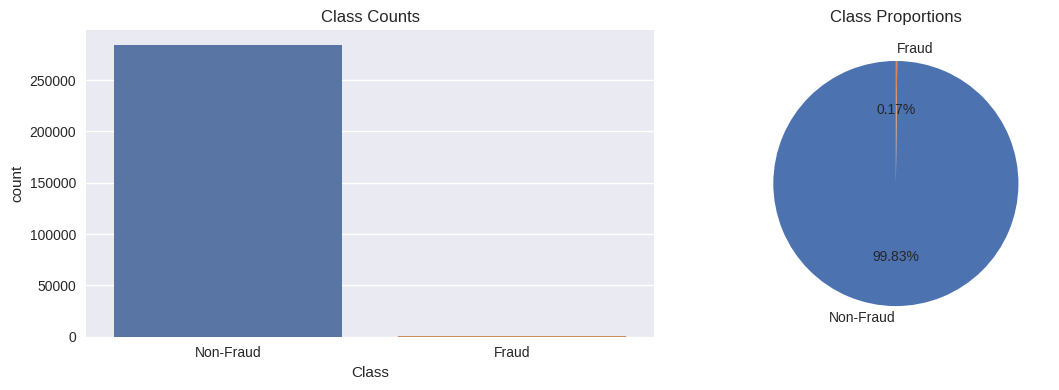

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Bar
sns.countplot(x=df['Class'], ax=ax[0], palette=['#4c72b0','#dd8452'])
ax[0].set_xticklabels(['Non-Fraud','Fraud'])
ax[0].set_title('Class Counts')

# Pie
counts = df['Class'].value_counts()
ax[1].pie(counts, labels=['Non-Fraud','Fraud'], autopct='%1.2f%%', startangle=90, colors=['#4c72b0','#dd8452'])
ax[1].set_title('Class Proportions')

plt.tight_layout()
plt.show()


This shows how imbalanced the dataset is (very few fraud cases). This motivates unsupervised anomaly methods.

## 2.2 Transaction Amount distribution

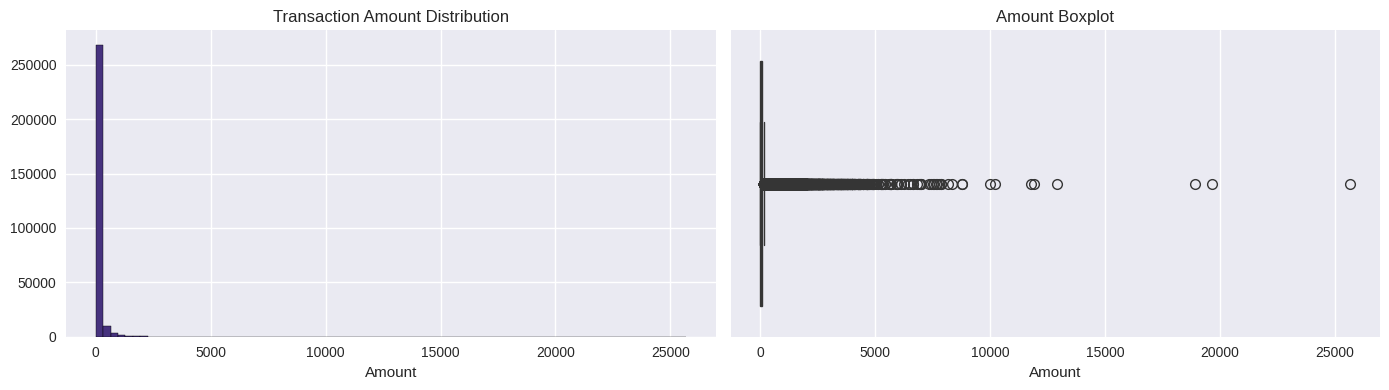

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

# Histogram (log scale to show tail)
ax[0].hist(df['Amount'], bins=80, edgecolor='black')
ax[0].set_title('Transaction Amount Distribution')
ax[0].set_xlabel('Amount')

# Boxplot to show outliers
sns.boxplot(x=df['Amount'], ax=ax[1])
ax[1].set_title('Amount Boxplot')

plt.tight_layout()
plt.show()


Explanation:
Visualizes transaction amounts. Fraud often appears in high amounts but not always — distribution is skewed and has heavy tails.

## 2.3 PCA explained variance + 2D projection

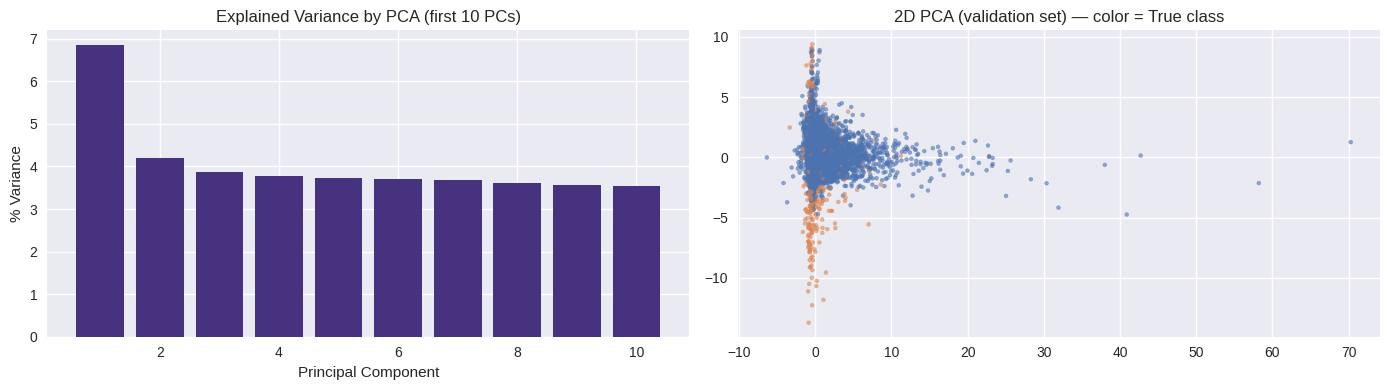

Explained variance by first 2 PCs: 0.110636916181939


In [ ]:
pca_full = PCA(n_components=10, random_state=42)
pca_full.fit(X_train_scaled)  # fit on training
explained = pca_full.explained_variance_ratio_

fig, ax = plt.subplots(1,2, figsize=(14,4))
# Scree plot (first 10 components)
ax[0].bar(range(1, len(explained)+1), explained*100)
ax[0].set_title('Explained Variance by PCA (first 10 PCs)')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('% Variance')

# 2D PCA scatter (use PCA fitted on training but transform validation full)
pca2 = PCA(n_components=2, random_state=42)
pca2.fit(X_train_scaled)
X_val_2d = pca2.transform(X_val_scaled)

ax[1].scatter(X_val_2d[:,0], X_val_2d[:,1], c=val_df['Class'].map({0:'#4c72b0',1:'#dd8452'}), s=8, alpha=0.6)
ax[1].set_title('2D PCA (validation set) — color = True class')

plt.tight_layout()
plt.show()

print("Explained variance by first 2 PCs:", explained[:2].sum())


Explanation:
2D PCA projection visualizes where fraud points fall (they are sparse), helpful for later plotting anomalies found by the autoencoder.

## 2.4 Feature correlation (heatmap) + amount vs label boxplot


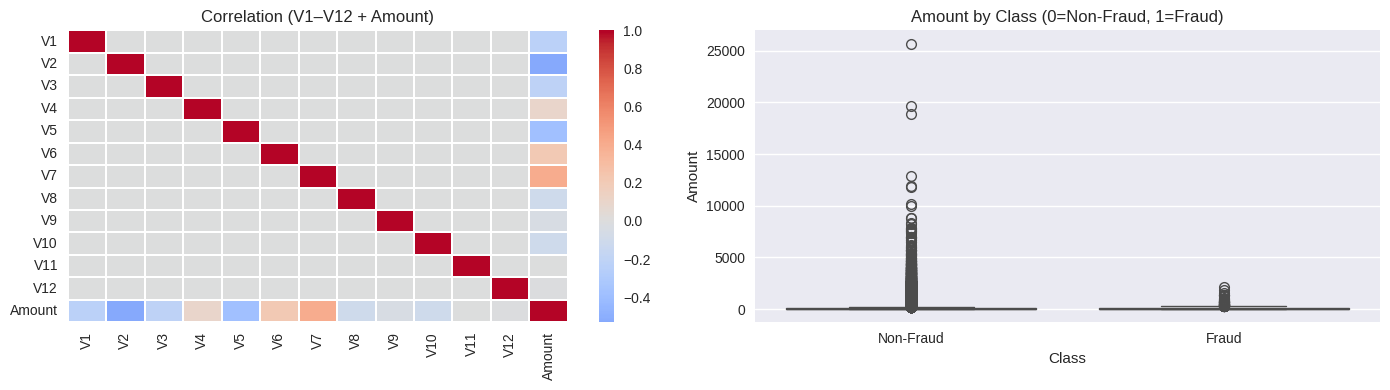

In [ ]:

# Plot correlation of a subset (V1–V12) to keep plot readable
cols_corr = [f'V{i}' for i in range(1,13) if f'V{i}' in df.columns] + ['Amount']
fig, axes = plt.subplots(1,2, figsize=(14,4))

# Heatmap for subset
sns.heatmap(df[cols_corr].corr(), ax=axes[0], cmap='coolwarm', center=0, annot=False, linewidths=0.3)
axes[0].set_title('Correlation (V1–V12 + Amount)')

# Amount vs Class boxplot
sns.boxplot(x='Class', y='Amount', data=df, ax=axes[1], palette=['#4c72b0','#dd8452'])
axes[1].set_title('Amount by Class (0=Non-Fraud, 1=Fraud)')
axes[1].set_xticklabels(['Non-Fraud','Fraud'])

plt.tight_layout()
plt.show()


Explanation:
Heatmap (subset) helps see linear relationships. Boxplot shows that fraud transactions often include higher amounts, but distribution overlaps — not a clean separator.

## 2.5 Web-like summary figure (transactions per time slice + fraud rate)


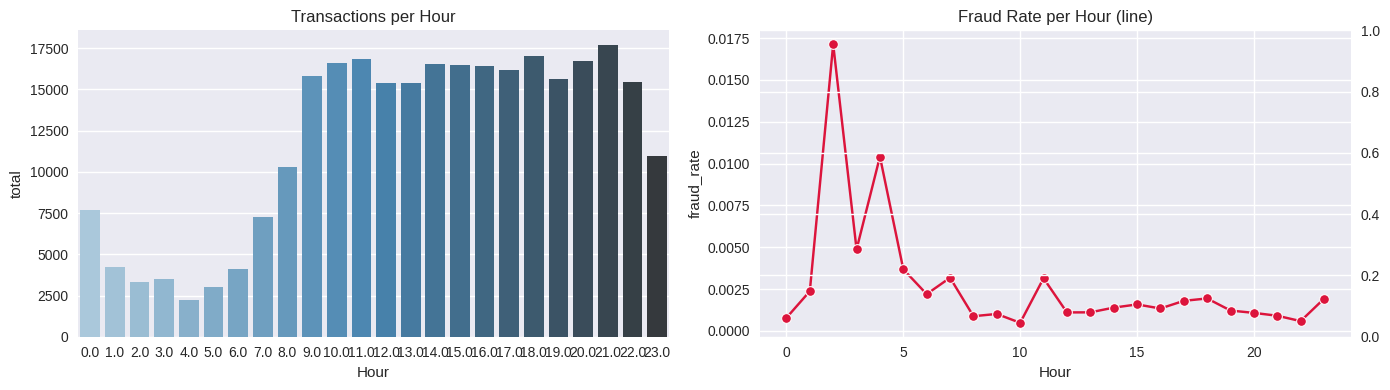

In [ ]:
# Create hour bucket from Time (seconds -> hour)
df['Hour'] = (df['Time'] // 3600) % 24
hourly = df.groupby('Hour').agg(total=('Class','count'), frauds=('Class','sum')).reset_index()
hourly['fraud_rate'] = hourly['frauds'] / hourly['total']

fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.barplot(x='Hour', y='total', data=hourly, ax=ax[0], palette='Blues_d')
ax[0].set_title('Transactions per Hour')

ax2 = ax[1].twinx()
sns.lineplot(x='Hour', y='fraud_rate', data=hourly, marker='o', ax=ax[1], color='crimson')
ax[1].set_title('Fraud Rate per Hour (line)')

plt.tight_layout()
plt.show()


Explanation:
Shows daily patterns — how transaction volume and fraud rate vary by hour. Good for operational insights (when to monitor more intensely).

## 3. Modeling — Deep Autoencoder for Anomaly Detection

A deep autoencoder is a neural network trained to reconstruct normal data.  
It compresses the input into a lower-dimensional space (encoding) and then tries to rebuild it (decoding).

⚠️ Key Idea:
- **Normal data** → reconstructs well → **low reconstruction error**
- **Anomalies/outliers** → reconstructs poorly → **high reconstruction error**

We also include:
- **GPU/TPU support** for faster training.
- **IsolationForest** as a traditional baseline model.


## 3.1 Enable GPU / TPU Acceleration


In [ ]:
import torch

# Check for GPU or TPU
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


Using device: cuda


## 3.2 Convert Data to Tensors

In [ ]:
# Convert numpy arrays → torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
X_all_tensor   = torch.tensor(X_all_scaled, dtype=torch.float32).to(device)

## 3.3 Autoencoder Architecture

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


input_dim = X_train_scaled.shape[1]
model = Autoencoder(input_dim).to(device)
model


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=29, bias=True)
  )
)

Explanation:
This is a deep autoencoder (32 → 16 bottleneck) that learns normal patterns and fails on fraud patterns.

## 3.4 Training Loop

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30
epoch_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.6f}")


Epoch [1/30] - Loss: 0.336183
Epoch [2/30] - Loss: 0.111571
Epoch [3/30] - Loss: 0.071182
Epoch [4/30] - Loss: 0.057818
Epoch [5/30] - Loss: 0.050779
Epoch [6/30] - Loss: 0.042561
Epoch [7/30] - Loss: 0.038800
Epoch [8/30] - Loss: 0.035872
Epoch [9/30] - Loss: 0.033619
Epoch [10/30] - Loss: 0.033545
Epoch [11/30] - Loss: 0.033815
Epoch [12/30] - Loss: 0.030259
Epoch [13/30] - Loss: 0.028540
Epoch [14/30] - Loss: 0.028088
Epoch [15/30] - Loss: 0.026847
Epoch [16/30] - Loss: 0.025373
Epoch [17/30] - Loss: 0.025566
Epoch [18/30] - Loss: 0.023927
Epoch [19/30] - Loss: 0.023456
Epoch [20/30] - Loss: 0.024574
Epoch [21/30] - Loss: 0.024228
Epoch [22/30] - Loss: 0.022571
Epoch [23/30] - Loss: 0.020865
Epoch [24/30] - Loss: 0.021364
Epoch [25/30] - Loss: 0.021940
Epoch [26/30] - Loss: 0.021385
Epoch [27/30] - Loss: 0.020006
Epoch [28/30] - Loss: 0.019974
Epoch [29/30] - Loss: 0.020087
Epoch [30/30] - Loss: 0.019962


Explanation:
Model is trained on non-fraud only (unsupervised) to reconstruct normal transactions.

## 3.5 Reconstruction Error on Validation Set

In [ ]:
model.eval()

with torch.no_grad():
    reconstructed_val = model(X_val_tensor).cpu().numpy()

val_errors = ((X_val_scaled - reconstructed_val)**2).mean(axis=1)


Explanation:
We measure how much the model struggles to reconstruct each transaction.

## 3.6 Threshold Selection

In [ ]:
# Fraud samples in validation dataset
val_labels = val_df['Class'].values

# Threshold = mean + 3*std (tunable)
threshold = val_errors[val_labels == 0].mean() + 3 * val_errors[val_labels == 0].std()
print("Threshold:", threshold)


Threshold: 0.2757051742109691


Explanation:
Fraud errors are usually much higher → threshold separates them.

## 3.7 Predict fraud on VALIDATION SET

In [ ]:
val_pred = (val_errors > threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(val_labels, val_pred))
print(classification_report(val_labels, val_pred, digits=4))


[[28138   294]
 [   89   403]]
              precision    recall  f1-score   support

           0     0.9968    0.9897    0.9932     28432
           1     0.5782    0.8191    0.6779       492

    accuracy                         0.9868     28924
   macro avg     0.7875    0.9044    0.8356     28924
weighted avg     0.9897    0.9868    0.9879     28924



## 3.8 Predict Anomalies on FULL DATASET

In [ ]:
with torch.no_grad():
    reconstructed_all = model(X_all_tensor).cpu().numpy()

all_errors = ((X_all_scaled - reconstructed_all)**2).mean(axis=1)
df['AE_Error'] = all_errors
df['AE_Anomaly'] = (all_errors > threshold).astype(int)

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,Hour,AE_Error,AE_Anomaly
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.015016,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.002974,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.066696,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.034834,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.012991,0


Explanation:
Adds two new columns:

* AE_Error = reconstruction error
* AE_Anomaly = 1 if anomaly, 0 if normal

**bold text**

## 3.9 Predict for the Fraudulent Transactions Using Logistic regression and Chi-Square Test

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------
# expects the Kaggle credit card dataset
df = pd.read_csv("/content/drive/MyDrive/Credit Cards frauds/creditcard.csv")

# -------------------------------------------------------------------
# 2. Basic feature engineering
# -------------------------------------------------------------------
# Time in hours (cyclic behaviour) – optional but useful
df["Hour"] = (df["Time"] // 3600) % 24

# log-transform Amount to reduce heavy tail
df["Amount_log"] = np.log1p(df["Amount"])

# Drop raw Time (and optionally raw Amount – we keep both engineered + raw)
df = df.drop(columns=["Time"])

# Target and features
y = df["Class"].values
X = df.drop(columns=["Class"])

feature_names = X.columns.tolist()

# -------------------------------------------------------------------
# 3. Train / test split (stratified because of heavy imbalance)
# -------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# -------------------------------------------------------------------
# Helper: evaluation function
# -------------------------------------------------------------------
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    roc = roc_auc_score(y_te, y_proba)
    pr_auc = average_precision_score(y_te, y_proba)

    print(f"\n===== {name} =====")
    print(f"ROC-AUC:      {roc:.4f}")
    print(f"PR-AUC:       {pr_auc:.4f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_te, y_pred))
    print("Classification report (fraud is class 1):")
    print(classification_report(y_te, y_pred, digits=4))

    return roc, pr_auc, model


# -------------------------------------------------------------------
# 4. Baseline: Logistic Regression on scaled features
# -------------------------------------------------------------------
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

log_reg_baseline = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

evaluate_model(
    "Baseline LogisticRegression (all features, std scaled)",
    log_reg_baseline,
    X_train_std,
    y_train,
    X_test_std,
    y_test
)

# -------------------------------------------------------------------
# 5. Chi-square feature selection (requires non-negative features)
# -------------------------------------------------------------------
scaler_mm = MinMaxScaler()  # maps features to [0,1]
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

# select top k features according to chi2
k_chi2 = 15  # you can tune this
chi2_selector = SelectKBest(score_func=chi2, k=k_chi2)
X_train_chi2 = chi2_selector.fit_transform(X_train_mm, y_train)
X_test_chi2 = chi2_selector.transform(X_test_mm)

selected_idx_chi2 = chi2_selector.get_support(indices=True)
selected_features_chi2 = [feature_names[i] for i in selected_idx_chi2]
print("\n[Chi2] Selected features:", selected_features_chi2)

log_reg_chi2 = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

evaluate_model(
    f"LogisticRegression + Chi2 (k={k_chi2})",
    log_reg_chi2,
    X_train_chi2,
    y_train,
    X_test_chi2,
    y_test
)

# -------------------------------------------------------------------
# 6. PCA for dimensionality reduction
# -------------------------------------------------------------------
# work on standardized features
n_pca = 10  # tune this (8–20 is reasonable)
pca = PCA(n_components=n_pca, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("\n[PCA] Explained variance by first", n_pca, "components:",
      pca.explained_variance_ratio_.sum())

log_reg_pca = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

evaluate_model(
    f"LogisticRegression + PCA (n_components={n_pca})",
    log_reg_pca,
    X_train_pca,
    y_train,
    X_test_pca,
    y_test
)

# -------------------------------------------------------------------
# 7. RFE (Recursive Feature Elimination) with Logistic Regression
# -------------------------------------------------------------------
# we reuse standardized features
base_estimator = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

n_rfe = 15  # number of features to keep – tune this
rfe = RFE(estimator=base_estimator, n_features_to_select=n_rfe, step=1)
X_train_rfe = rfe.fit_transform(X_train_std, y_train)
X_test_rfe = rfe.transform(X_test_std)

selected_idx_rfe = rfe.get_support(indices=True)
selected_features_rfe = [feature_names[i] for i in selected_idx_rfe]
print("\n[RFE] Selected features:", selected_features_rfe)

log_reg_rfe = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

evaluate_model(
    f"LogisticRegression + RFE (n_features={n_rfe})",
    log_reg_rfe,
    X_train_rfe,
    y_train,
    X_test_rfe,
    y_test
)

# -------------------------------------------------------------------
# 8. Stronger non-linear model on best feature set (RandomForest)
#    Here we use the chi2-selected features, but you can swap with RFE.
# -------------------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

evaluate_model(
    "RandomForest + Chi2-selected features",
    rf,
    X_train_chi2,
    y_train,
    X_test_chi2,
    y_test
)

print("\nDone.")



===== Baseline LogisticRegression (all features, std scaled) =====
ROC-AUC:      0.9717
PR-AUC:       0.7200
Confusion matrix:
[[55370  1494]
 [    9    89]]
Classification report (fraud is class 1):
              precision    recall  f1-score   support

           0     0.9998    0.9737    0.9866     56864
           1     0.0562    0.9082    0.1059        98

    accuracy                         0.9736     56962
   macro avg     0.5280    0.9409    0.5462     56962
weighted avg     0.9982    0.9736    0.9851     56962


[Chi2] Selected features: ['V1', 'V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Hour', 'Amount_log']

===== LogisticRegression + Chi2 (k=15) =====
ROC-AUC:      0.9708
PR-AUC:       0.6829
Confusion matrix:
[[55444  1420]
 [    9    89]]
Classification report (fraud is class 1):
              precision    recall  f1-score   support

           0     0.9998    0.9750    0.9873     56864
           1     0.0590    0.9082    0.1108     

**Here you can see we have successfully trained the model for detecting the fraudulent transactions and got the pretty good confusion matrix**